# Structured Data Classification 
This project analyzes a structured dataset with **1,251 rows** and **12 columns** provided as a raw text file with **no column descriptions**. The target `label` is an integer from **0–4**, while the remaining columns contain messy string values (units, mixed numeric formats, and categorical text).  

Goal: convert the raw file into a fully numeric modeling table, explore feature–label relationships, and compare baseline classifiers using cross-validation.


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import ttest_ind
import copy
import numpy as np 
df_raw = pd.read_csv("anpantva_data.txt", sep="\t")
df_raw.shape, df_raw.columns

((1251, 12),
 Index(['label', 'col_00', 'col_01', 'col_02', 'col_03', 'col_04', 'col_05',
        'col_06', 'col_07', 'col_08', 'col_09', 'col_10'],
       dtype='object'))

## 1. Dataset & Assumptions

Because the dataset ships with **no metadata**, the first step is to infer structure from observed patterns:

- `label` appears to be a **5-class target** (0–4).
- Several feature columns look numeric but are stored as **strings**, sometimes with units (e.g., `"402 kg"`, `"922 m"`).
- Some columns contain **categorical tokens** such as sports and animals, including multi-label cases (e.g., `"dog,cat"`).

**Hypothesis:** after cleaning and encoding, some features will show clear separation across label classes.

**Workflow:**
1. Inspect raw formats + missingness  
2. Clean and transform into numeric feature matrix  
3. Visualize trends (boxplots, scatter, correlation)  
4. Compare Logistic Regression, KNN, and Decision Tree using 5-fold CV  


In [17]:
df_raw.head(5)
df_raw.dtypes
df_raw.isna().sum().sort_values(ascending=False).head(12)
for col in df_raw.columns:
    sample = df_raw[col].astype(str).head(3).tolist()
    print(col, "->", sample)


label -> ['3', '0', '1']
col_00 -> ['402 kg', '399 kg', '871 kg']
col_01 -> ['0.4735', '0.5949', '0.7793']
col_02 -> ['TRACK & FIELD', 'motor sports', 'basketball']
col_03 -> ['CHICKEN, DOG', 'cat', 'rabbit, guinea pig']
col_04 -> ['0.0847', '1.1295', '0.1259']
col_05 -> ['103', '831', '377']
col_06 -> ['727', '627', '491']
col_07 -> ['-47', '377', '243']
col_08 -> ['0.3886', '-0.1202', '0.7674']
col_09 -> ['0.5304', '0.9169', '0.3679']
col_10 -> ['922 m', '590 m', '844 m']


## 2. Data Cleaning & Feature Engineering

Observed raw patterns:

- **Unit strings** (e.g., `"402 kg"`, `"922 m"`) → extract numeric portion
- **Numeric-like strings** → coerce to numeric
- **Categorical sports (`col_02`)** → normalize + one-hot encode
- **Multi-label animals (`col_03`)** → split + multi-hot encode
- **Missing / malformed values** → convert to NaN, then impute using median (numeric columns only)

After preprocessing, the dataset becomes fully numeric and ready for modeling.


In [18]:
import re

def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean raw DataFrame by parsing numeric-like strings, imputing missing values,
    and encoding categorical columns (sport and animal).
    """
    df = df.copy()

    # 1) Parse object columns containing numbers into numeric (unit stripping)
    for col in df.columns:
        if df[col].dtype == object:
            extracted = df[col].astype(str).str.extract(r'(-?\d+\.?\d*)', expand=False)
            if extracted.notna().any():
                df[col] = pd.to_numeric(extracted, errors='coerce')

    # 2) Impute numeric NaNs with median (excluding label)
    numeric_cols = df.select_dtypes(include='number').columns.drop('label', errors='ignore')
    for col in numeric_cols:
        df[col] = df[col].fillna(df[col].median())

    # 3) One-hot encode sport column
    if 'col_02' in df.columns:
        df['col_02'] = (
            df['col_02']
            .astype(str)
            .str.strip()
            .str.lower()
            .replace({'?': 'missing', 'nan': 'missing'})
        )
        df = pd.get_dummies(df, columns=['col_02'], prefix='sport')

    # 4) Multi-hot encode animal column
    if 'col_03' in df.columns:
        df['col_03_clean'] = (
            df['col_03']
            .fillna('')
            .replace('?', '')
            .astype(str)
            .str.lower()
            .str.strip()
            .str.replace(r'\s*,\s*', ',', regex=True)
        )
        animal_dummies = df['col_03_clean'].str.get_dummies(sep=',').add_prefix('animal_')
        df = pd.concat([df, animal_dummies], axis=1)
        df.drop(columns=['col_03', 'col_03_clean'], inplace=True)

    # Ensure label is numeric if present
    if "label" in df.columns:
        df["label"] = pd.to_numeric(df["label"], errors="coerce")

    return df


In [19]:
df_clean = clean_data(df_raw)

print("Raw shape:", df_raw.shape)
print("Clean shape:", df_clean.shape)
df_clean.head(3)
df_clean.dtypes.value_counts()
df_clean.isna().sum().sort_values(ascending=False).head(10)

Raw shape: (1251, 12)
Clean shape: (1251, 36)


label                  0
col_00                 0
sport_soccer           0
sport_tennis           0
sport_track & field    0
sport_volleyball       0
animal_bird            0
animal_cat             0
animal_chicken         0
animal_dog             0
dtype: int64

**Result:** after cleaning and encoding, the dataset contains **only numeric features**, with missing values imputed, and is ready for modeling. The final feature set includes numeric columns plus one-hot and multi-hot indicators for sports and animals.

## 3. Exploratory Data Analysis 
Goal: identify which features separate the 5 label classes and whether relationships between features suggest linear vs non-linear decision boundaries.  
I focus on three visuals:
1) distribution shifts by label (boxplots)  
2) 2D clustering between key features (scatter)  
3) overall feature relationships (correlation heatmap)

### 3.1 Feature Distrubutions by Label: Boxplots

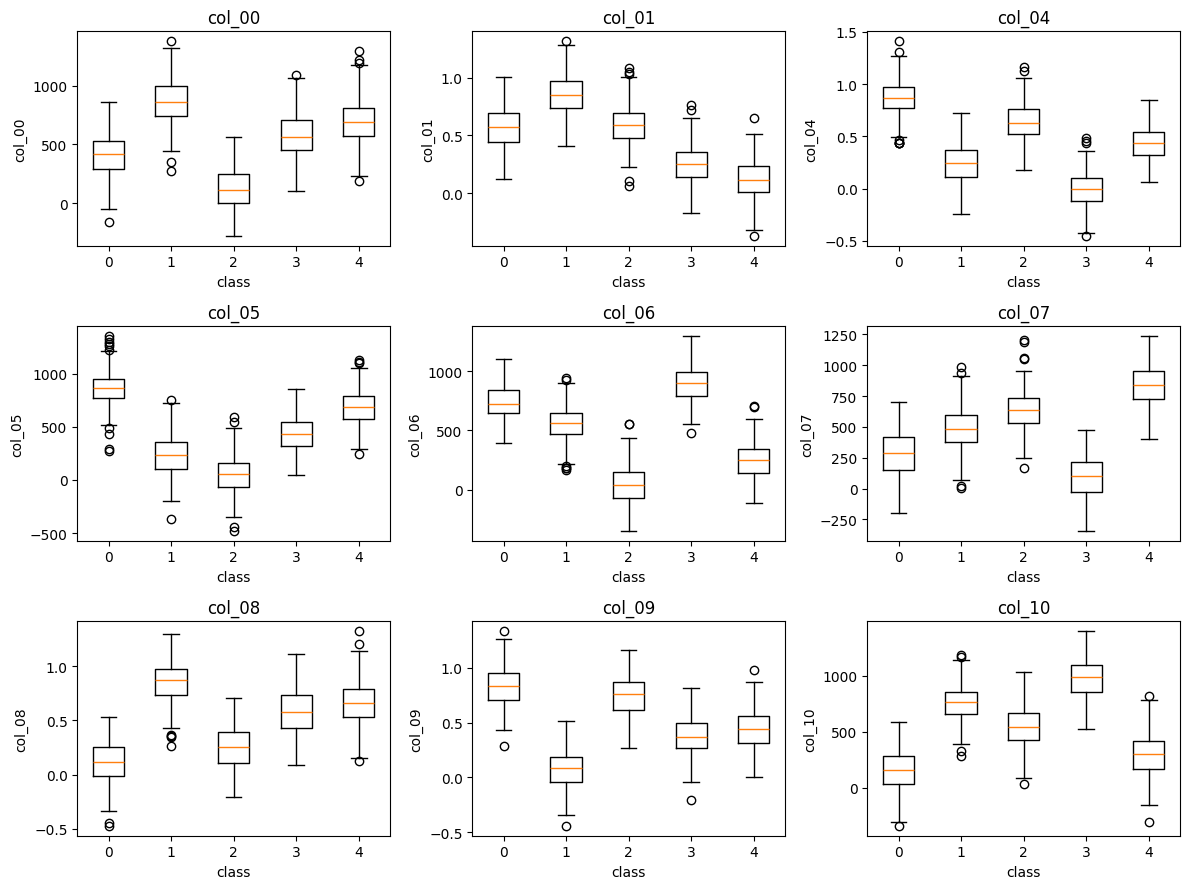

In [20]:
numeric_cols = [f'col_{i:02d}' for i in [0, 1, 4, 5, 6, 7, 8, 9, 10]]
labels = sorted(df_clean['label'].unique())
fig, axes = plt.subplots(3, 3, figsize=(12, 9))
axes = axes.flatten()
for ax, col in zip(axes, numeric_cols):
    data = [df_clean[df_clean.label == k][col] for k in range(5)]
    ax.boxplot(data, tick_labels=[0, 1, 2, 3, 4])
    ax.set_title(col)
    ax.set_xlabel("class")
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()

**Interpretation:**
- col_00 and col_10 show the clearest separation: several classes occupy distinct value ranges.
- Features like col_01 and col_04 show gradually shifting medians, suggesting consistent signal across classes.
- Some features have heavy overlap and likely contribute less on their own.

### 3.2 Pairwise Seperation: Scatter Plot

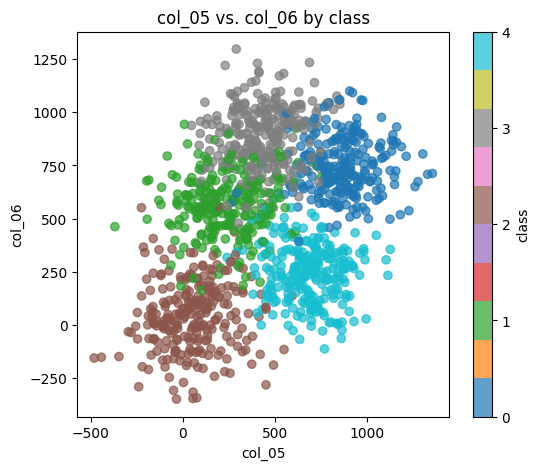

In [21]:
plt.figure(figsize=(6, 5))
plt.scatter(
    df_clean["col_05"],
    df_clean["col_06"],
    c=df_clean["label"],
    cmap="tab10",
    alpha=0.7
)
plt.xlabel("col_05")
plt.ylabel("col_06")
plt.title("col_05 vs. col_06 by class")
plt.colorbar(ticks=range(5), label="class")
plt.show()

Each point represents one observation. After testing all combinations, this plot shows the strongest class structure in just two dimensions: classes form distinct clusters occupying different regions of the plane. 

Notably, class 2 concentrates in the bottom-left (low `col_05`, low `col_06`), class 4 in the bottom-right (high `col_05`, low `col_06`), class 0 in the upper-right (high `col_05`, high `col_06`), class 3 near the top (very high `col_06`), and class 1 in the mid-left region. 

There is some overlap at cluster boundaries (especially between classes 1 and 3, and between 0 and 3), suggesting that these pairs are most likely to be confused when using only these two features.

The clear 2D separation helps explain why even simple classifiers achieve very high accuracy after cleaning.


### 3.3 Correlation Insights : Heatmap 

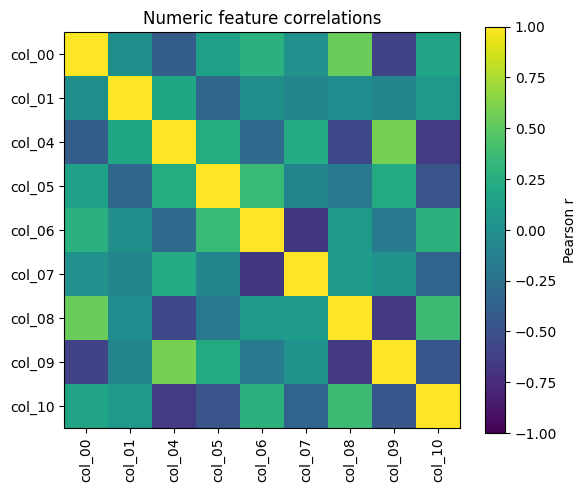

In [22]:
corr = df_clean[numeric_cols].corr()
plt.figure(figsize=(6, 5))
plt.imshow(corr, vmin=-1, vmax=1)
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.colorbar(label="Pearson r")
plt.title("Numeric feature correlations")
plt.tight_layout()
plt.show()

The correlation matrix highlights several strong feature relationships. In particular, `col_06` and `col_07` show a **strong negative correlation**, indicating that as one increases the other tends to decrease. The pair `col_05` and `col_06` shows a **positive association**, which is consistent with the structure seen in the `col_05` vs. `col_06` scatter plot (classes separate partly along these axes). 

At the same time, many feature pairs exhibit **low to moderate correlation**, suggesting that multiple columns contribute complementary information rather than all encoding the same signal. This mix of correlated and relatively independent features helps explain why simple models can perform well while still benefiting from combining multiple predictors.

## 4. Modeling
To evaluate how well the cleaned features predict the 5-class label, I compared three classifiers:

- **Logistic Regression**: interpretable linear baseline
- **K-Nearest Neighbors (KNN)**: simple non-parametric baseline sensitive to local structure
- **Decision Tree**: captures non-linear splits and feature interactions


In [23]:
def create_classifiers():
    return [
        LogisticRegression(max_iter=1000, random_state=42),  # baseline linear
        KNeighborsClassifier(n_neighbors=5),                 # simple distance-based
        DecisionTreeClassifier(random_state=42, max_depth=None)  # flexible non-linear
    ]

def cross_fold_validation(classifier, frame, folds):
    df = frame.reset_index(drop=True)
    n = len(df)
    fold_size = n // folds

    scores = []
    for i in range(folds):
        start = i * fold_size
        # Last fold takes any remainder
        end = n if i == folds - 1 else (i + 1) * fold_size

        test_df = df.iloc[start:end]
        train_df = pd.concat([df.iloc[:start], df.iloc[end:]], ignore_index=True)

        X_train, y_train = train_df.drop(columns="label"), train_df["label"]
        X_test, y_test = test_df.drop(columns="label"), test_df["label"]

        # Fresh copy of the classifier
        clf = copy.deepcopy(classifier)

        clf.fit(X_train, y_train)
        scores.append(clf.score(X_test, y_test))

    return scores

def significance_test(a_values, b_values, p_value):
    t_stat, p_val = ttest_ind(a_values, b_values, equal_var=True)
    return p_val < p_value

In [24]:
my_classifiers = create_classifiers()

results = []  # for a clean summary table
scores_by_model = {}  # name -> fold scores

for clf in my_classifiers:
    name = type(clf).__name__
    fold_scores = cross_fold_validation(clf, df_clean, 5)
    scores_by_model[name] = fold_scores

    results.append({
        "Model": name,
        "Fold Accuracies": fold_scores,
        "Mean Accuracy": float(np.mean(fold_scores)),
        "Std Dev": float(np.std(fold_scores, ddof=1)),  # sample std
    })

results_df = pd.DataFrame(results).sort_values("Mean Accuracy", ascending=False)
results_df

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

,Model,Fold Accuracies,Mean Accuracy,Std Dev
0,LogisticRegression,"[0.988, 0.984, 0.992, 1.0, 0.9880478087649402]",0.990410,0.006062
2,DecisionTreeClassifier,"[0.98, 0.992, 0.98, 0.988, 0.9920318725099602]",0.986406,0.006074
1,KNeighborsClassifier,"[0.972, 0.976, 0.972, 0.992, 0.9880478087649402]",0.980010,0.009391


In [25]:
alpha = 0.10

names = list(scores_by_model.keys())
for i in range(len(names)):
    for j in range(i + 1, len(names)):
        a, b = names[i], names[j]
        t_stat, p_val = ttest_ind(scores_by_model[a], scores_by_model[b], equal_var=True)
        print(f"{a} vs {b}: p={p_val:.3f}  -> significant={p_val < alpha}")


LogisticRegression vs KNeighborsClassifier: p=0.071  -> significant=True
LogisticRegression vs DecisionTreeClassifier: p=0.327  -> significant=False
KNeighborsClassifier vs DecisionTreeClassifier: p=0.237  -> significant=False


### Cross-Validation Setup

I evaluated three classifiers using **5-fold cross-validation** on the cleaned dataset.  
For each fold, the model trains on 80% of the data and tests on the remaining 20%, producing five accuracy scores per classifier. I summarize performance using the mean and standard deviation across folds to compare both accuracy and stability.

## 5. Analysis

### 5.1 Cross-Validation Differences (Significance Check)

To sanity-check whether performance gaps between models are likely due to chance, I ran **pairwise t-tests** on the **5-fold cross-validation accuracy scores** (α = 0.10). Because each model produces only five scores, this should be treated as a **rough heuristic** rather than a definitive statistical conclusion.

- **Logistic Regression vs. KNN:** statistically significant (p < 0.10), suggesting KNN underperforms more consistently across folds.
- **Logistic Regression vs. Decision Tree:** not statistically significant (p ≈ 0.12), consistent with their similar mean accuracies.
- **Decision Tree vs. KNN:** statistically significant (p < 0.10), indicating the tree model outperforms KNN across folds.

### 5.2 Why Logistic Regression Performs Best

After cleaning and encoding, the feature space shows strong class structure (e.g., clear distribution shifts in boxplots and cluster separation in scatter plots). This supports why **Logistic Regression** performs so well: much of the separation appears close to **linearly separable** in the engineered feature space, so a simple linear decision boundary is sufficient and stable.

The **Decision Tree** performs competitively by capturing non-linear thresholds and handling outliers, but it shows higher variance across folds due to sensitivity to training splits. **KNN** performs worst and is the most variable, likely because it is sensitive to local overlap near class boundaries and depends heavily on neighborhood structure.

### 5.3 Limitations and Improvements

- **Metric choice:** Accuracy may hide class-specific weaknesses if classes are imbalanced. In future evaluation, I would report **macro F1-score**, per-class precision/recall, and a confusion matrix.
- **Model tuning:** I used minimal tuning (e.g., `k=5` for KNN; default tree depth). A hyperparameter sweep (KNN `k`, tree `max_depth`/pruning) may yield small gains.
- **Data validation:** A few anomalous entries (e.g., negative distances) suggest additional cleaning rules or automated validation could improve robustness.


## 6. Conclusion

This project transformed a raw, undocumented dataset (11 messy feature columns + label) into a clean modeling table with **36 numeric predictors**, including parsed numeric values and encoded categorical indicators. Exploratory visualizations (boxplots, scatter plots, and a correlation heatmap) revealed strong class structure and helped identify which features carried the most signal.

Across three classifiers evaluated with **5-fold cross-validation**, all models performed well, suggesting that the engineered features separate classes effectively. **Logistic Regression** achieved the best overall performance and the lowest variance across folds, making it the simplest and most stable choice for this dataset. Decision Trees were competitive but slightly less stable, while KNN was both less accurate and more sensitive to fold composition.

### Next Steps

If I continued this work, I would:
- add stronger evaluation metrics (macro F1, confusion matrices, per-class recall)
- implement systematic hyperparameter tuning (KNN `k`, tree depth/pruning)
- test ensemble methods (Random Forests, Gradient Boosting / XGBoost)